## Data Processing Using Machine Learning Classifiers

> ### Artificial Intelligence - CA4
> ### Shakiba Bolbolian Khah - 810196426

- **About**:

To use different methods of machine learning to process different data and predic new one, has been one of the important field recently. `Python` has different libraries which provide us various machine learning methods and `Sklearn` is a useful one. During this assignment we process a data collected from different shopping malls which show their customers information. It also provides us whether customers came back later for shopping or not. We implement different classifiers for this data to predict `Is Back` columns.


### Phase 0

- **Data Preprocessing**:

To use classifiers like `Decision Tree`, `KNN`, `Logistic Regression`, etc, we first should preprocess raw data.


> **1.Negative Amount Omition**:
> Raw data has some defects such as negative amount for total count and total quantity columns. In order to solve this, I just considered rows in which total price and total quantity both have positive or zero amount.
>
>**2.Date Procesing**:
> At a glance we can understand that having a column for date can not help us so much because it is approximately unique for each row. However we can gain useful information from gain data such as month, day, year, season, day of week. We can also recognize whether the day of shopping was weekend or not. This information helps us more to find relation between attributes. `Panda`'s to_datetime function helps us to do this. At the end of steps Date column had been omitted and new columns like Year, Day, Month, IsWeekend, etc had been added.
>
>**3.Data Scaling**:
When you’re working with a learning model, it is important to scale the features to a range which is centered around zero. This is done so that the variance of the features are in the same range. If a feature’s variance is orders of magnitude more than the variance of other features, that particular feature might dominate other features in the dataset, which is not something we want happening in our model. The aim here is to to achieve Gaussian with zero mean and unit variance. `Sklearn` provides us standard scaler which is useful enough. However we do not need to scale data for all classifiers.
>
>>>*__important__:* In preprocessing phase, I did not scale data and it had been scaled based on need.
>>
>>**Decision Tree:** tree-based algorithms (decision trees and random forests) are not affected by scaling. A node of a tree partitions your data into 2 sets by comparing a feature value so it's not affected by different scales.
>>
>>**K Nearest Neghibours:** 
The k nearest neighbours algorithm relies on majority voting based on class membership of 'k' nearest samples for a given test point. The nearness of samples is typically based on Euclidean distance. In some cases without normalization, all the nearest neighbours are aligned in the direction of the axis with the smaller range which can lead to incorrect classification. It is important to scale all attributes because all of them should have values in same range in order to prevent fake magnitude.
>>
>>**Logistic Regression:**
It seems it is better not to scale data for linear regression because they can be negative. If a coefficient is strongly positive, it means that the corresponding feature is very much correlated with the positive class. If it is strongly negative, then its means that the feature is strongly correlated with the negative class. If the coefficient is close to zero, then it means that the feature is not correlated much with either the positive or the negative class. So if we want to compare the importance of each feature, we should compare the absolute values of the coefficients.
> 
>
>**4.Encoding**:
> Most of machine learning algorithms can not handle categorical variables unless we convert them into numerical ones. This dataset has categorical variables too. Country column contains categorical variables which should convert into numerical ones. There are two different approaches we can adopt to convert data whose summaries came below.
>>**Label Encoding:** 
In this method we assign each unique category, an unique numberical amount. By this way all vars with a spaecial category will turn into a numeric amounts. The numbers starts from 0 to N-1 (N is the number of distinct categories in dataset). Although label encoding is useful for methods like desicion tree and KNN which see the amount of a variable as label, it bring problem in some cases. The problem here is, since there are different numbers in the same column, the model will misunderstand the data to be in some kind of order, 0 < 1 < 2. But this isn’t the case at all. To overcome this problem, we use one hot encoder.
It is notable that label encoding is usually used when the categorical feature is ordinal or the number of categories is quite large as one hot encoding can lead to high memory consumption
>>
>>**One Hot Encoding:**
This methods creates N columns(N is number of unique labels), each one belongs to a label. In each row, all columns except which has the same category as data, have 0 amount and that one is 1. By this way we do not have previous problem any more. But one hot encoding can consume large space if number of feature is high and this causes low performance. Some methods which consider a value for each data like logistic regression, use one hot encoding. It is also useful when the categorical feature is not ordinal.
>



- **Training Process**:

After preprocessing data we need to split it into 2 groups: training and testing data. `train_test_split` function does this for us. It can does splitting with or without `random_state` parameter which control the random number generator. Since the given dataset is not large enough to respond efficiently with no random_state, I had no choice except selecting special random_state to get desired accuracy.


- **Implementation**:

In [1]:
import pandas as pd
import numpy as np 
import datetime
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer 
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, VotingClassifier
import matplotlib.pyplot as plt


In [2]:
cols = ['Customer ID','Total Quantity','Total Price','Country','Date','Is Back','Purchase Count']
df = pd.read_csv('data.csv', usecols=cols)
df = df[(df['Total Quantity']>=0) & (df['Total Price']>=0)]
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month
df['Year'] = df['Date'].dt.year
df['Day'] = df['Date'].dt.day
df['Quarter'] = df['Date'].dt.quarter
df['WeekDay'] = df['Date'].dt.dayofweek
df['isWeekend'] = np.where(df['WeekDay'].isin([5,6]),1,0)

labelencoder = LabelEncoder()
df['Country cat'] = labelencoder.fit_transform(df['Country'])
df['Is Back'] = labelencoder.fit_transform(df['Is Back'])

names = {}
for i in range(len(df['Country'])): names[df.iloc[i]['Country cat']] = df.iloc[i]['Country']
df = df.drop(columns= ['Country','Date'])

df.head()

Customer ID  Total Quantity  Total Price  Is Back  Purchase Count  Month  \
1        12552              85        13.52        1              19     10   
2        13192             298        15.90        1              33      5   
3        16934             399         8.30        0              62     10   
4        14976              27        11.90        1              16      1   
5        17937             564       204.00        1              13     12   

   Year  Day  Quarter  WeekDay  isWeekend  Country cat  
1  2011   31        4        0          0           18  
2  2011   18        2        2          0           35  
3  2011   16        4        6          1           35  
4  2011   17        1        0          0           35  
5  2010   12        4        6          1           35

- **Information Gain Calculation**:

As shown above, `mutual_info_classif` function calculates information gain of data set by recieving features and target data. It also recieve a boolean array which shows which column has discrete value. In this data set all columns except total quantity, total price and purchase count are considered discrete. The result is shown in chart 1. As customer ID data is unique per row, it has high information gain which is not usable since it can not give us much information for further data. So information gain for other column except customer ID is shown in chart 2. It seems month column can halp us more compared to others and brings us more infomration about data behaviour. As well as this other columns have information gain depends on their information gain value.

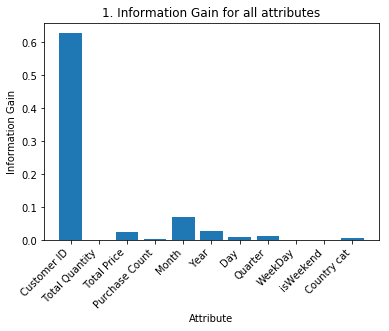

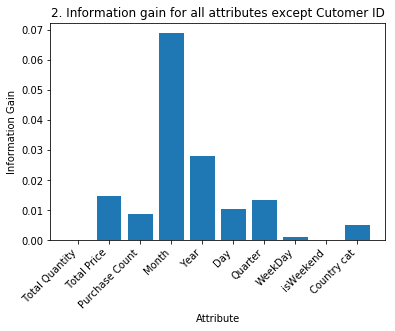

In [3]:
def plotGain(informationGain, columns, titleMsg):   
    fig = plt.figure()
    plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
    plt.bar(columns, informationGain)
    plt.xlabel('Attribute')
    plt.ylabel('Information Gain')
    plt.title(titleMsg)
    plt.show()

def calculateGain():
    discreteArray = [True, False, False, False, True, True, True, True, True, True, True]
    y = df['Is Back']
    X = df.drop(columns=['Is Back'])
    informationGain = mutual_info_classif(X, y, discrete_features = discreteArray)
    plotGain(informationGain, X.columns, "1. Information Gain for all attributes")


    discreteArray = [False, False, False, True, True, True, True, True, True, True]
    y = df['Is Back']
    X = df.drop(columns=['Is Back', 'Customer ID'])
    informationGain = mutual_info_classif(X, y, discrete_features = discreteArray)
    plotGain(informationGain, X.columns, "2. Information gain for all attributes except Cutomer ID")

calculateGain()

In [4]:
def scaleData(data, attributes):
    scaler = StandardScaler()
    data[attributes]= scaler.fit_transform(data[attributes])
    return data

def plotLineChart(x, y1, y2, label1, label2, xlabel, ylabel, title):
    plt.plot(x, y1, label = label1, c = 'c') 
    plt.plot(x, y2, label = label2, c = 'm') 
    plt.xlabel(xlabel) 
    plt.ylabel(ylabel) 
    plt.title(title) 
    plt.legend() 
    plt.show() 

### Phase I

- **Decision Tree**


>**1.Preprocessing:**
>
> As said before, for decision tree, we do not have to scale data since it works with label. Also it is enough to encode country data with label encoding method. As mentioned before customer ID does not contain useful information, so this column has not been passed to classifier.
>
>**2.Hyperparameters:**
>
> Maximum depth is the most important hyperparameter in decision tree. The theoretical maximum depth a decision tree can achieve is one less than the number of training samples, but no algorithm will let us reach this point for obvious reasons, one big reason being overfitting. By determining it, the classifier expands tree until it reaches maximum depth. In this assignment, I calculate tree with max depth from 2 to 9(number of features) whose details will be discussed later.
>
>**3.Accuracy and Overfitting:**
>
> As notable in graph 3, by increasing tree depth in each iteration, test accuraacy approximately increases as well as train accuracy. However after certain threshold, it begins to decrease while train accuracy increases continously. If we increase depth, train accuracy will increase more and more. This means that it get overfitted on train data and model will completely get formed based on train amount. On the other hand, it will work weakly on test data because of overfitting. So perfect depth is one in which both test and train accuracy have acceptable values.

- **Implementation**

Decision tree max depth:  2
Accuracy:  0.7625298329355609
Precision:  0.7651898075311134
Recall:  0.7625298329355609
------
Decision tree max depth:  3
Accuracy:  0.7553699284009546
Precision:  0.7592913375705551
Recall:  0.7553699284009546
------
Decision tree max depth:  4
Accuracy:  0.7613365155131265
Precision:  0.7610878614641727
Recall:  0.7613365155131265
------
Decision tree max depth:  5
Accuracy:  0.7541766109785203
Precision:  0.7465295143679875
Recall:  0.7541766109785203
------
Decision tree max depth:  6
Accuracy:  0.7422434367541766
Precision:  0.7344573523840596
Recall:  0.7422434367541766
------
Decision tree max depth:  7
Accuracy:  0.7398568019093079
Precision:  0.7294417134568104
Recall:  0.7398568019093079
------
Decision tree max depth:  8
Accuracy:  0.7243436754176611
Precision:  0.7104838771016903
Recall:  0.7243436754176611
------
Decision tree max depth:  9
Accuracy:  0.7147971360381862
Precision:  0.6992176093171316
Recall:  0.7147971360381862
------


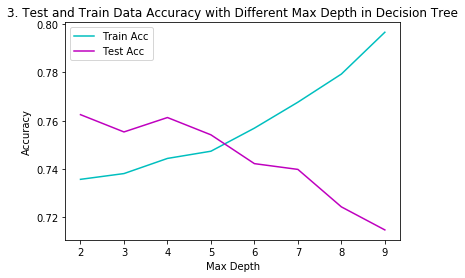

Best Depth (According to Test Accuracy):  2


In [5]:
trainAccuracy = []
testAccuracy = []
bestTreeDepth = 2

randomState = 27
y = df['Is Back']
X = df.drop(columns=['Is Back', 'Customer ID'])

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state= randomState)

def decisionTreeClassifier():
    for i in range(2,10):
        clf = tree.DecisionTreeClassifier(max_depth=i)
        clf = clf.fit(XTrain, yTrain)
        yPredTest = clf.predict(XTest)
        yPredTrain = clf.predict(XTrain)
        print("Decision tree max depth: ", i)
        testAccuracy.append(accuracy_score(yTest, yPredTest))
        trainAccuracy.append(accuracy_score(yTrain, yPredTrain))
        global bestTreeDepth
        if(testAccuracy[-1] >= testAccuracy[bestTreeDepth-2]):
            bestTreeDepth = i
        
        print("Accuracy: ", testAccuracy[-1])
        print("Precision: ", precision_score(yTest, yPredTest, average='weighted'))
        print("Recall: ", recall_score(yTest, yPredTest, average='weighted'))
        print("------")
        

decisionTreeClassifier()
plotLineChart(range(2,10), trainAccuracy, testAccuracy, "Train Acc", "Test Acc", "Max Depth", "Accuracy",
              "3. Test and Train Data Accuracy with Different Max Depth in Decision Tree")

print("Best Depth (According to Test Accuracy): ", bestTreeDepth)
# clf = tree.DecisionTreeClassifier(max_depth= bestDepth)
# clf = clf.fit(XTrain, yTrain)
# tree.plot_tree(clf)

- **K Nearest Neighbours**


>**1.Preprocessing:**
>
> As said before, for KNN, we have to scale data since it works based on distance. As well as decision tree, it is enough to encode country data with label encoding method. As mentioned before customer ID does not contain useful information, so this column has not been passed to classifier.
>
>**2.Hyperparameters:**
>
> Neighbours number is the parameter which plays significant role in KNN. Research has shown that no optimal number of neighbors suits all kind of data sets. Each dataset has it's own requirements. So I tried different number between 1 to 100 (more values are not considered because in practice, best neighbour number was less than 100 and after special number, test and train accuracy had similar behavior. Since we have 2 label as target, I just considered odd number of neighbours in order to avoid equality in voting. Generally having even neighbours number with even target labels causes fluctuation in tesr and train accuracy.
>
>**3.Accuracy and Overfitting:**
>
> As notable in graph 4, by increasing neighbours number in each iteration, test accuraacy approximately increases while train accuracy decreases. Usually in KNN using less neighbours would actually lead to overfitting. This also relates to the number of samples that we have and the noise on these samples. For instance if we have two billion samples and if we use k = 1, model definitely get overfitted. But with increaing number of neighbours, model desires to check other data values and by this way, it avoids overfitting. Obviously, After a while and by increaing neighbours number in algorithm, accuracy can decrease.




- **Implementation**

K Nearest Neighbours Classifier with Neighbour Num(Test Data):  1
Accuracy:  0.6408114558472554
Precision:  0.6485020699628096
Recall:  0.6408114558472554
------
K Nearest Neighbours Classifier with Neighbour Num(Test Data):  3
Accuracy:  0.6599045346062052
Precision:  0.649605642297492
Recall:  0.6599045346062052
------
K Nearest Neighbours Classifier with Neighbour Num(Test Data):  5
Accuracy:  0.7004773269689738
Precision:  0.683408695859771
Recall:  0.7004773269689738
------
K Nearest Neighbours Classifier with Neighbour Num(Test Data):  7
Accuracy:  0.7100238663484487
Precision:  0.6936997977114486
Recall:  0.7100238663484487
------
K Nearest Neighbours Classifier with Neighbour Num(Test Data):  9
Accuracy:  0.711217183770883
Precision:  0.693217054355101
Recall:  0.711217183770883
------
K Nearest Neighbours Classifier with Neighbour Num(Test Data):  11
Accuracy:  0.7159904534606205
Precision:  0.6976786177183056
Recall:  0.7159904534606205
------
K Nearest Neighbours Classifier 

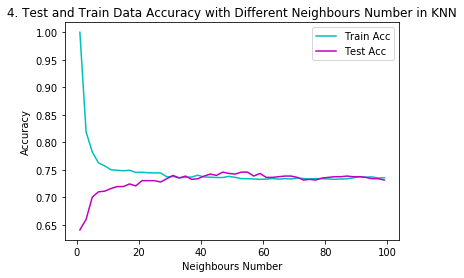

Best Nighbours Num (According to Test Accuracy):  55


In [11]:
trainAccuracy = []
testAccuracy = []
bestNeighbourNum = 1
bestAcc = 0

attributes = ['Total Quantity','Total Price', 'Purchase Count', 'Country cat', 
              'isWeekend', 'WeekDay', 'Quarter', 'Day', 'Year', 'Month']
classifierData = df.copy()
classifierData = scaleData(classifierData, attributes )

randomState = 41
y = classifierData['Is Back']
X = classifierData.drop(columns=['Is Back', 'Customer ID'])

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state= randomState)

def KNNClassifier():
    data = [0,0,0]
    for i in range(1,100,2):
        neigh = KNeighborsClassifier(n_neighbors=i)
        neigh = neigh.fit(XTrain, yTrain)
        yPredTest = neigh.predict(XTest)
        yPredTrain = neigh.predict(XTrain)
        testAccuracy.append(accuracy_score(yTest, yPredTest))
        trainAccuracy.append(accuracy_score(yTrain, yPredTrain))
        global bestNeighbourNum, bestAcc
        if(testAccuracy[-1] >= bestAcc):
            bestNeighbourNum = i
            bestAcc = testAccuracy[-1]
            
        if(i == bestNeighbourNum):
            print("K Nearest Neighbours Classifier with Neighbour Num(Test Data): ", i)
            print("Accuracy: ", testAccuracy[-1])
            print("Precision: ", precision_score(yTest, yPredTest, average='weighted'))
            print("Recall: ", recall_score(yTest, yPredTest, average='weighted'))
            print("------")
            data = [trainAccuracy[-1], precision_score(yTrain, yPredTrain, average='weighted'),
                   recall_score(yTrain, yPredTrain, average='weighted')]
    print("Train Data")
    print("Accuracy: ", data[0])
    print("Precision: ", data[1])
    print("Recall: ", data[2])
    print("------")
            

KNNClassifier()
plotLineChart(range(1,100,2), trainAccuracy, testAccuracy, "Train Acc", "Test Acc", "Neighbours Number",
              "Accuracy", "4. Test and Train Data Accuracy with Different Neighbours Number in KNN")

print("Best Nighbours Num (According to Test Accuracy): ", bestNeighbourNum)

- **Logistic Regression**


>**1.Preprocessing:**
>
> As said before, for logistic regression, there is no need to scale data, but it needs one hot encoding for country column; because this algorithm consider amount of each cell as its value. For instance if a country has label 31, it will have way value in logistic regression than a country with country label 0. According to information gain of month, and also distribution of week day and quarter amount, I applied one hot encoding on them too. Day column has same sitauition too, but it made data set very big after one hot encoding without significant effect and since it had less iinformation gain, I did not change it. Year column with numberical categorical variable had not been changed because years amounts were close to each other(in short period). As mentioned before, customer ID does not contain useful information, so this column has not been passed to classifier.
>
>**2.Accuracy and Overfitting:**
>
> As it was shown it has close accuracy to previous two models. Overfitting can not be detected.


- **Implementation**

In [7]:
LogisticDf = pd.concat([df, pd.get_dummies(df['Country cat'])], axis=1)
LogisticDf = pd.concat([LogisticDf, pd.get_dummies(LogisticDf['Month'])], axis=1)
LogisticDf = pd.concat([LogisticDf, pd.get_dummies(LogisticDf['WeekDay'])], axis=1)
LogisticDf = pd.concat([LogisticDf, pd.get_dummies(LogisticDf['Quarter'])], axis=1)
LogisticDf = LogisticDf.rename(columns=names)
LogisticDf = LogisticDf.drop(columns=['Country cat', 'Month', 'WeekDay', 'Quarter'])

randomState = 28
y = LogisticDf['Is Back']
X = LogisticDf.drop(columns=['Is Back', 'Customer ID'])

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state= randomState)

def logisticClassifier():
    clf = LogisticRegression(max_iter = 750).fit(XTrain, yTrain)
    yPredTest = clf.predict(XTest)
    yPredTrain = clf.predict(XTrain)
    print("Logistic Regression Model:\n")
    print("Test Data")
    print("Accuracy: ", accuracy_score(yTest, yPredTest))
    print("Precision: ", precision_score(yTest, yPredTest, average='weighted'))
    print("Recall: ", recall_score(yTest, yPredTest, average='weighted'))
    print("------")
    print("Train Data")
    print("Accuracy: ", accuracy_score(yTrain, yPredTrain))
    print("Precision: ", precision_score(yTrain, yPredTrain, average='weighted'))
    print("Recall: ", recall_score(yTrain, yPredTrain, average='weighted'))
    
    
logisticClassifier()

Logistic Regression Model:

Test Data
Accuracy:  0.747016706443914
Precision:  0.7426947526321799
Recall:  0.747016706443914
------
Train Data
Accuracy:  0.7306658704090774
Precision:  0.7172363137941837
Recall:  0.7306658704090774


### Phase II

- **Bagging**


>**1.Preprocessing:**
>
> Just like decision tree and KNN, data had been label encoded. For decision tree bagging, we did not scale too, however KNN needs scaling.
>
>**2.Accuracy:**
>
> As it was shown it has close accuracy to previous two models. However it is more variable than decision tree and KNN and I don't know why!?
>
>**3.Overfitting:**
>
> Generally ensembles are machine learning methods for combining predictions from multiple separate models. Bagging is an ensemble which attempts to reduce the chance overfitting complex models. First it creates numbers of sub samples of the original sample, them it trains a large number of strong learners in parallel which one of these sub samples. A strong learner is a model that's relatively unconstrained. Bagging then combines all the strong learners together in order to smooth out their predictions.
By this way it reduce the effect of any single sample on final model.


- **Implementation**

In [14]:
def baggingClassifier(model):
    if(model == "KNN"):
        global bestNeighbourNum
        baggingDF = df.copy()
        clf = BaggingClassifier(KNeighborsClassifier(n_neighbors=bestNeighbourNum),max_samples=0.5, max_features=0.5)
        attributes = ['Total Quantity','Total Price', 'Purchase Count', 'Country cat', 
              'isWeekend', 'WeekDay', 'Quarter', 'Day', 'Year', 'Month']
        baggingDF = scaleData(baggingDF, attributes )
        y = baggingDF['Is Back']
        X = baggingDF.drop(columns=['Is Back', 'Customer ID'])
        XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state= 27)

    else:
        global bestTreeDepth
        baggingDF = df.copy()
        clf = BaggingClassifier(tree.DecisionTreeClassifier(max_depth= bestTreeDepth), max_samples=0.5, max_features=0.5)
        y = baggingDF['Is Back']
        X = baggingDF.drop(columns=['Is Back', 'Customer ID'])
        XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.25, random_state= 27)

    clf = clf.fit(XTrain, yTrain)
    yPredTest = clf.predict(XTest)
    yPredTrain = clf.predict(XTrain)
    print("Bagging Model Classifier: ",model,"\n")
    print("Test Data")
    print("Accuracy: ", accuracy_score(yTest, yPredTest))
    print("Precision: ", precision_score(yTest, yPredTest, average='weighted'))
    print("Recall: ", recall_score(yTest, yPredTest, average='weighted'))
    print("------")
    print("Train Data")
    print("Accuracy: ", accuracy_score(yTrain, yPredTrain))
    print("Precision: ", precision_score(yTrain, yPredTrain, average='weighted'))
    print("Recall: ", recall_score(yTrain, yPredTrain, average='weighted'))
    print("------")
    
    
baggingClassifier("KNN")
baggingClassifier("Decision Tree")

Bagging Model Classifier:  KNN 

Test Data
Accuracy:  0.7267303102625299
Precision:  0.7406875233939492
Recall:  0.7267303102625299
------
Train Data
Accuracy:  0.7217079725291131
Precision:  0.7159731618120982
Recall:  0.7217079725291131
------
Bagging Model Classifier:  Decision Tree 

Test Data
Accuracy:  0.7478510028653295
Precision:  0.7515857441412835
Recall:  0.7478510028653295
------
Train Data
Accuracy:  0.7273885350318471
Precision:  0.7106509195420281
Recall:  0.7273885350318471
------


- **Bootstrapping:**

> **1.Operation:**
>
> The bootstrap method is a statistical technique for estimating quantities about a population by averaging estimates from multiple small data samples.Importantly, samples are constructed by drawing observations from a large data sample one at a time and returning them to the data sample after they have been chosen. This allows a given observation to be included in a given small sample more than once. This approach to sampling is called sampling with replacement.
>The bootstrap method can be used to estimate a quantity of a population. This is done by repeatedly taking small samples, calculating the statistic, and taking the average of the calculated statistics. The procedure can also be used to estimate the skill of a machine learning model.
>
> **2.Effect on Variance and Bias:**
>> - **Bias:** We say our model is biased if it systematically under or over predicts the target variable.
>>
>> - **Variance:** Variance captures the generalizability of the model. it is a measure of how much our prediction would change if we trained it on different data. High variance typicaly means that we are overfitting to our training data, finding patterns and complexity that are a product of randomness as opposed to some real trend.
>
> According to these definitions, and the explanation which was given about bagging overfitting before(bagging is one of bootstrapping methods), generally bootstrapping decreases overfitting and the less overfitted model, the less variance. So bootstrapping decrease variance compared to other models. As well as this, because this model creates sub sample from original ones with replacement, it leads to sub samples contain different distribution of classes. To explain more, consider a sample with 3 classes, if 50% of that belongs to class A, 30% belongs to class B and remained 20% belongs to class C, and we implement a classifier on the original model, it will probably be a biased model. By applying bootstrapping in some sub samples, these ratio will change so the probility of having a biased model will reduce.


- **Random Forest**


>**1.Preprocessing:**
>
> Since random forest is based on decision tree, we do not need scaling and also label encoding is enough.
>
>**2.Hyperparameters:**
>
> By testing different ranges, I found two better ranges for max depth and estimators. 
> But what are their effects?
>
>> - **Max Depth:** We see 5 graphs below which show accuracy for special estimator numbers with different max depth. We can notice as the max depth of the decision tree increases, the performance of the model over the training set increases continuously. On the other hand as the max depth value increases, the performance over the test set increases initially but after a certain point, it starts to decrease rapidly.
>>
>> - **Estimator Number:** We might say that more trees should be able to produce a more generalized result,but by choosing more number of trees, the time complexity of the Random Forest model also increases.
Graph 5 shows us that the performance of the model sharply increases and then stagnates at a certain level with little fluctuations. This means that choosing a large number of estimators in a random forest model is not the best idea, although it will not degrade the model!

- **Implementation**

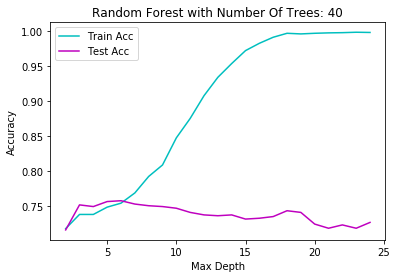

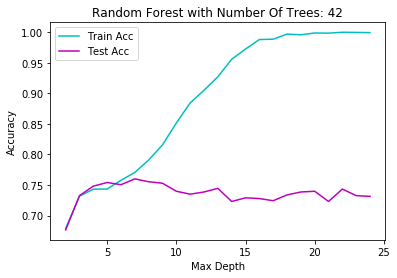

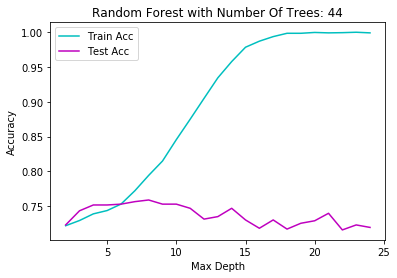

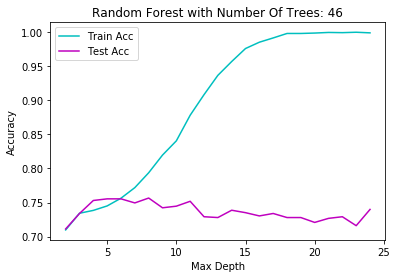

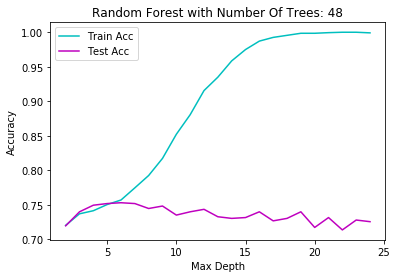

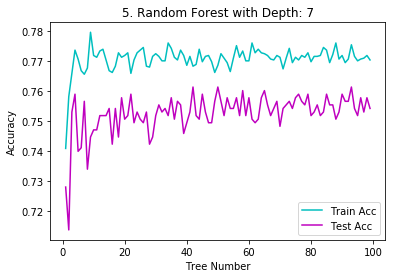

Random Forest Max Depth:  7   Number of Trees:  42
Accuracy:  0.7601431980906921
Precision:  0.7570162087506886
Recall:  0.7601431980906921


In [15]:
randomState = 28
y = df['Is Back']
X = df.drop(columns=['Is Back', 'Customer ID'])

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state= randomState)

bestAcc = 0
bestDepth = 1
bestNum = 1
bestPrec = 0
bestRecall = 0

def randomForestClassifier():
    for treeNum in range(40,50,2):
        testAccuracy = []
        trainAccuracy = []
        for depth in range(2, 25):
            clf = RandomForestClassifier(max_depth= depth, n_estimators = treeNum)
            clf = clf.fit(XTrain, yTrain)
            yPredTest = clf.predict(XTest)
            yPredTrain = clf.predict(XTrain)
            testAccuracy.append(accuracy_score(yTest, yPredTest))
            trainAccuracy.append(accuracy_score(yTrain, yPredTrain))
            global bestDepth, bestAcc, bestNum, bestPrec, bestRecall, br
            if(testAccuracy[-1] >= bestAcc):
                bestDepth = depth
                bestNum = treeNum
                bestAcc = testAccuracy[-1]
                bestPrec = precision_score(yTest, yPredTest, average='weighted')
                bestRecall = recall_score(yTest, yPredTest, average='weighted')

        plotLineChart(range(2,25), trainAccuracy, testAccuracy, "Train Acc", "Test Acc", "Max Depth"
              , "Accuracy", "Random Forest with Number Of Trees: "+ str(treeNum))
        

    testAccuracy = []
    trainAccuracy = []
    for treeNum in range(1,100):
        clf = RandomForestClassifier(max_depth= bestDepth, n_estimators = treeNum)
        clf = clf.fit(XTrain, yTrain)
        yPredTest = clf.predict(XTest)
        yPredTrain = clf.predict(XTrain)
        testAccuracy.append(accuracy_score(yTest, yPredTest))
        trainAccuracy.append(accuracy_score(yTrain, yPredTrain))
        
    plotLineChart(range(1,100), trainAccuracy, testAccuracy, "Train Acc", "Test Acc", "Tree Number"
              , "Accuracy", "5. Random Forest with Depth: "+ str(bestDepth))

randomForestClassifier()

print("Random Forest Max Depth: ", bestDepth,"  Number of Trees: ", bestNum)
print("Accuracy: ", bestAcc)
print("Precision: ", bestPrec)
print("Recall: ", bestRecall)

- **Hard Voting**


>**1.Preprocessing:**
>
> We had to scale and encode data in one hot encoding mode because of KNN and logistic regression.
>
>**2.Accuracy:**
>
> Test accuracy is close to mean of decision tree, KNN and logistic regression classifiers accuracy.
>
>**3.Hard Voting and other classifiers similarity:**
>
> It is obvious that the accuracy, precision and recall amount of hard voting classifier is close to mean of three classifiers' accuracy which were used in hard voting model. According to 3 evaluation values in decision tree, KNN and logistic regression, these models all have accuracy, precision and recall in range (70-76%), so implementing voting for them, can not be very useful since they announce same class for a new data with high probability. As a result implementing hard voting for these classifiers does not have a significant effect on model's accuracy compared to 3 ones.


- **Implementation**

In [16]:
hardVoteDF = pd.concat([df, pd.get_dummies(df['Country cat'])], axis=1)
hardVoteDF = hardVoteDF.rename(columns=names)
hardVoteDF = pd.concat([hardVoteDF, pd.get_dummies(hardVoteDF['Month'])], axis=1)
hardVoteDF = pd.concat([hardVoteDF, pd.get_dummies(hardVoteDF['WeekDay'])], axis=1)
hardVoteDF = pd.concat([hardVoteDF, pd.get_dummies(hardVoteDF['Quarter'])], axis=1)
hardVoteDF = hardVoteDF.drop(columns=['Country cat', 'Month', 'WeekDay', 'Quarter'])

attributes = ['Total Quantity','Total Price', 'Purchase Count','isWeekend', 'Day', 'Year']
hardVoteDF = scaleData(hardVoteDF, attributes )

randomState = 28
y = hardVoteDF['Is Back']
X = hardVoteDF.drop(columns=['Is Back', 'Customer ID'])

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.20, random_state= randomState)


def hardVotingClassifier():
    global bestNeighbourNum, bestTreeDepth
    clf1 = tree.DecisionTreeClassifier(max_depth= bestTreeDepth)
    clf2 = KNeighborsClassifier(n_neighbors= bestNeighbourNum)
    clf3 = LogisticRegression(max_iter = 250)
    eclf1 = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('lr', clf3)], voting='hard')
    eclf1 = eclf1.fit(XTrain, yTrain)
    yPredTest = eclf1.predict(XTest)
    yPredTrain = eclf1.predict(XTrain)
    print("Hard Voting Model Classifier:")
    print("Test Data")
    print("Accuracy: ", accuracy_score(yTest, yPredTest))
    print("Precision: ", precision_score(yTest, yPredTest, average='weighted'))
    print("Recall: ", recall_score(yTest, yPredTest, average='weighted'))
    print("------")
    print("Train Data")
    print("Accuracy: ", accuracy_score(yTrain, yPredTrain))
    print("Precision: ", precision_score(yTrain, yPredTrain, average='weighted'))
    print("Recall: ", recall_score(yTrain, yPredTrain, average='weighted'))
    print("------")
    
    
hardVotingClassifier()

Hard Voting Model Classifier:
Test Data
Accuracy:  0.7482100238663485
Precision:  0.7428981414486118
Recall:  0.7482100238663485
------
Train Data
Accuracy:  0.7384293819050463
Precision:  0.7268350583934214
Recall:  0.7384293819050463
------


### References:

- **Phase 0:**

> - https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn
> - https://medium.com/analytics-vidhya/why-is-scaling-required-in-knn-and-k-means-8129e4d88ed7
> - https://medium.com/@julie.yin/use-one-hot-encoding-to-analyze-adult-income-data-and-some-bad-news-for-the-single-people-in-the-cef71f9d47b4
> - https://medium.com/@contactsunny/why-do-we-need-feature-scaling-in-machine-learning-and-how-to-do-it-using-scikit-learn-d8314206fe73
> - https://stackoverflow.com/questions/29842647/feature-scaling-required-or-not

- **Phase I:**

> - https://www.quora.com/Would-using-too-many-neighbors-in-the-k-nearest-neighbor-pattern-classification-algorithm-lead-to-overfitting-since-it-would-smooth-out-the-data
> - https://stats.stackexchange.com/questions/384542/how-to-prevent-overfitting-with-knn
> - https://stats.stackexchange.com/questions/107870/does-k-nn-with-k-1-always-implies-overfitting

- **Phase II:**

> - https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning
> - https://elitedatascience.com/overfitting-in-machine-learning
> - https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method